In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


# Generating random data
np.random.seed(1)
points = np.random.rand(6, 2)
data = points*10
threshold =5
l = 0.5
b =0.2 

The current approach uses a two-phase union-find strategy. In the first phase, it groups points based on a fixed threshold, and in the second phase, it refines these groupings based on an adjusted threshold that considers the number of points in a group and the average distance between them.

In [2]:
def average_distance(group, data):
    # print(group)
    n = len(group)
    # print(group)
    if n == 1:  # if there's only one point in the group
        return 0
    total_distance = sum(np.linalg.norm(data[group[i]] - data[group[j]]) for i in range(n) for j in range(n) if i != j)
    # print(total_distance)
    return total_distance / (n * (n - 1))

class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
        
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    
    def union(self, x, y):
        rootX = self.find(x)
        rootY = self.find(y)
        
        if rootX != rootY:
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
            else:
                self.parent[rootX] = rootY
                if self.rank[rootX] == self.rank[rootY]:
                    self.rank[rootY] += 1

In [3]:
# Phase 1: Initial Group Formation using only the threshold
dsu_phase1 = UnionFind(len(data))

for i in range(len(data)):
    for j in range(i+1, len(data)):
        if np.linalg.norm(data[i] - data[j]) < threshold:
            dsu_phase1.union(i, j)

# Extract the preliminary groups from Phase 1
groups_phase1 = {}
for i in range(len(data)):
    root = dsu_phase1.find(i)
    if root not in groups_phase1:
        groups_phase1[root] = []
    groups_phase1[root].append(i)
preliminary_groups = list(groups_phase1.values())

In [4]:
preliminary_groups

[[0, 1, 2, 3, 4, 5]]

In [5]:
group_thresholds = {}
for group in preliminary_groups:
    avg_dist = average_distance(group, data)
    group_thresholds[tuple(group)] = threshold - l * (len(group) - 1) - b * avg_dist


In [6]:
# Phase 2: Refinement using preliminary groups to adjust the threshold
dsu_phase2 = UnionFind(len(data))

# Using the adjusted threshold to perform the union operation for all points
for i in range(len(data)):
    for j in range(i+1, len(data)):
        # Getting the adjusted threshold for the group to which 'i' belongs in Phase 1
        i_root_phase1 = dsu_phase1.find(i)
        # Find the group in Phase 1 to which 'i' belongs
        i_group_phase1 = next(group for group in groups_phase1.values() if i_root_phase1 in group)
        adjusted_threshold = group_thresholds[tuple(i_group_phase1)]

        if np.linalg.norm(data[i] - data[j]) < adjusted_threshold:
            dsu_phase2.union(i, j)

# Extract the refined groups from Phase 2
groups_phase2_corrected = {}
for i in range(len(data)):
    root = dsu_phase2.find(i)
    if root not in groups_phase2_corrected:
        groups_phase2_corrected[root] = []
    groups_phase2_corrected[root].append(i)
refined_groups_corrected = list(groups_phase2_corrected.values())

refined_groups_corrected


[[0, 4, 5], [1], [2], [3]]

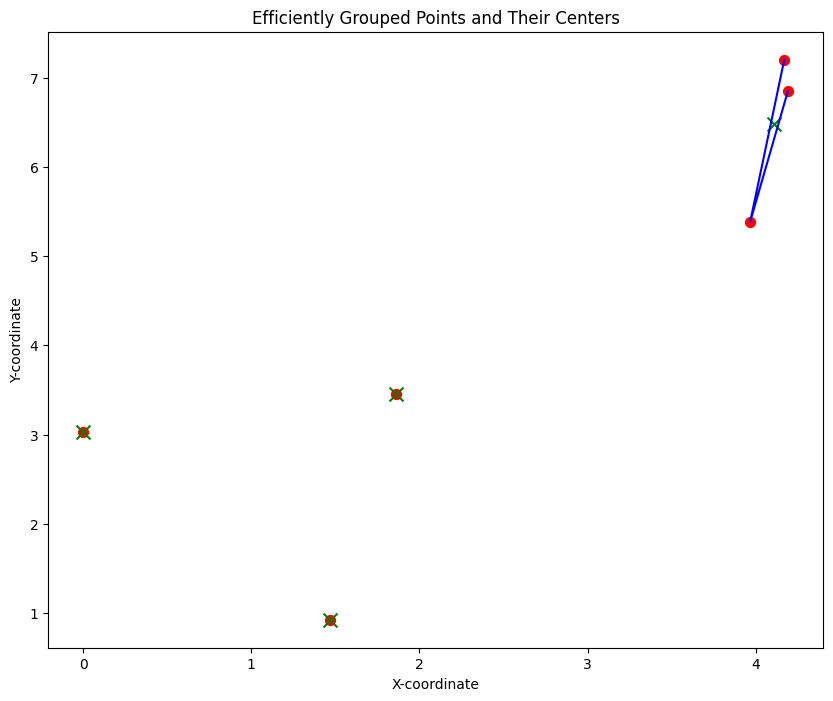

In [7]:
group_centers = [np.mean(data[group], axis=0) for group in refined_groups_corrected]
plt.figure(figsize=(10, 8))

plt.scatter(data[:, 0], data[:, 1], c='red', s=50)
# plt.scatter(data[:, 0], data[:, 1], c='red', s=50)
for group in refined_groups_corrected:
    plt.plot(data[group][:, 0], data[group][:, 1], 'b-')
plt.scatter(np.array(group_centers)[:, 0], np.array(group_centers)[:, 1], c='green', s=100, marker='x')
plt.title("Efficiently Grouped Points and Their Centers")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

In [8]:
data

array([[4.17022005e+00, 7.20324493e+00],
       [1.14374817e-03, 3.02332573e+00],
       [1.46755891e+00, 9.23385948e-01],
       [1.86260211e+00, 3.45560727e+00],
       [3.96767474e+00, 5.38816734e+00],
       [4.19194514e+00, 6.85219500e+00]])

iterative Code below:

In [9]:
def form_groups_using_adjusted_thresholds(data, group_thresholds, initial_threshold, l, b):
    dsu = UnionFind(len(data))

    for i in range(len(data)):
        for j in range(i+1, len(data)):
            # Determine which threshold to use (whichever is smaller)
            t_i = group_thresholds.get(dsu.find(i), initial_threshold)
            t_j = group_thresholds.get(dsu.find(j), initial_threshold)
            effective_threshold = min(t_i, t_j)

            if np.linalg.norm(data[i] - data[j]) < effective_threshold:
                dsu.union(i, j)

    # Extract groups and refine their thresholds
    groups = {}
    new_group_thresholds = {}
    for i in range(len(data)):
        root = dsu.find(i)
        if root not in groups:
            groups[root] = []
        groups[root].append(i)
    
    for group in groups.values():
        avg_dist = average_distance(group, data)
        new_group_thresholds[dsu.find(group[0])] = initial_threshold - l * (len(group) - 1) - b * avg_dist

    return list(groups.values()), new_group_thresholds


In [10]:
# Adjusting the iterative grouping function to pass the initial_threshold
def iterative_grouping_using_adjusted_thresholds(data, threshold, l, b, max_iterations=10):
    group_thresholds = {i: threshold for i in range(len(data))}
    previous_groups = None
    iterations = 0

    while iterations < max_iterations:
        current_groups, group_thresholds = form_groups_using_adjusted_thresholds(data, group_thresholds, threshold, l, b)
        
        # Check if groups have stabilized
        if current_groups == previous_groups:
            break

        previous_groups = current_groups
        iterations += 1

    return current_groups

# Apply the iterative grouping approach on the data with the adjusted parameters
final_groups_adjusted_approach = iterative_grouping_using_adjusted_thresholds(data, adjusted_threshold, l, b)
final_groups_adjusted_approach


[[0, 5], [1], [2], [3], [4]]

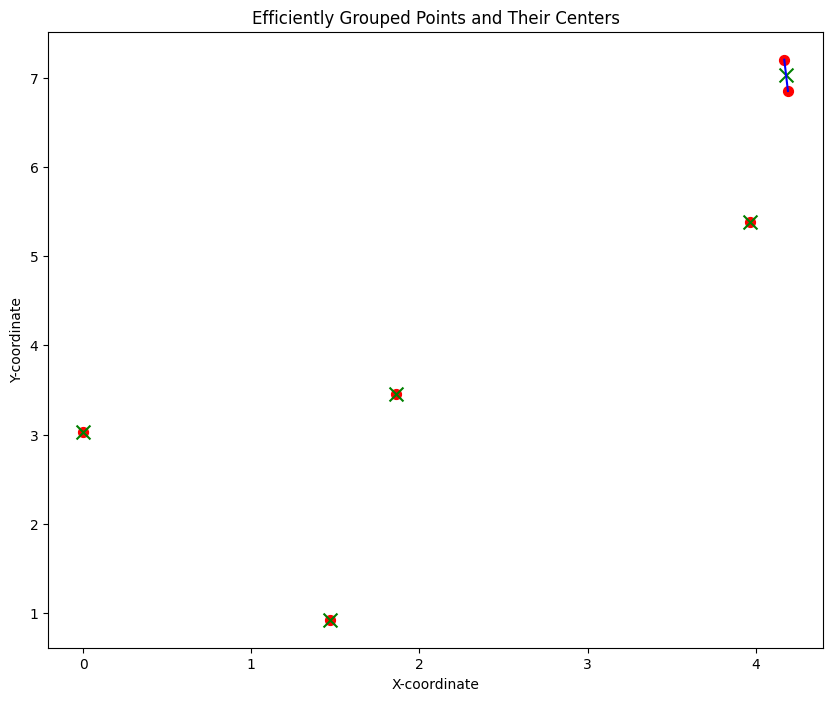

In [11]:
group_centers = [np.mean(data[group], axis=0) for group in final_groups_adjusted_approach]
plt.figure(figsize=(10, 8))

plt.scatter(data[:, 0], data[:, 1], c='red', s=50)
# plt.scatter(data[:, 0], data[:, 1], c='red', s=50)
for group in final_groups_adjusted_approach:
    plt.plot(data[group][:, 0], data[group][:, 1], 'b-')
plt.scatter(np.array(group_centers)[:, 0], np.array(group_centers)[:, 1], c='green', s=100, marker='x')
plt.title("Efficiently Grouped Points and Their Centers")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()